In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path

import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import io, base64
from IPython.display import Image, HTML

# alguns textos
aa

In [2]:
num_pop = 300
beta = 0.5
delta = 0.2
gamma = 0.15
d = 0.1
R0 = beta/gamma
I_0 = 8
T = 80
tempos = np.array(range(T+1))
num_sim = 60
print(f'Número básico de reprodução = {R0:.2f}')

Número básico de reprodução = 3.33


In [3]:
# estado inicial da população
pop_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, I_0)
pop_0[infectados_0] = 3*np.ones(I_0)
attr_pop_0 = dict([(i, {'estado': int(pop_0[i])}) for i in range(num_pop)])
print(pop_0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 3. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 3. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
def evolucao_SEIRD(pop_0, beta, delta,gamma, d, tempos, plot=False):

    SEIRD_Compartimental = namedtuple('SEIRD_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'beta',
                                     'delta',
                                     'gamma',
                                     'd',
                                     't_instantes',
                                     'S',
                                     'E',
                                     'I', 
                                     'R',
                                     'D',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, beta, delta, gamma, d):
        S, E, I, R, D = X
        dXdt = [- beta*I*S/N, beta*I*S/N - delta*E, delta*E - gamma*I - d*I, gamma*I, d*I]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = [num_pop, 0, 8, 0, 0]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, beta, delta, gamma, d))
    
    resultado = SEIRD_Compartimental(pop_0, num_pop, beta, delta, gamma, d, tempos,
                                   sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4],sol)
    return resultado
def analise_grafo(G, info=True, node_size=0, pos=None, hist=False):

    num_vertices = G.number_of_nodes()
    num_arestas = G.number_of_edges()
    num_arestas_por_vertice = [j for i,j in G.degree]
    num_medio_conexoes = 2*num_arestas/num_vertices

    if info:
        print(f'Número de arestas: {num_arestas}')
        print(f'Número de vértices: {num_vertices}')
        print(f'Número médio de conexões por indivíduo: {num_medio_conexoes:.1f}')

    if node_size:
        color = ['tab:blue', 'tab:purple','tab:red', 'tab:green', 'tab:brown']
        pop_estado = nx.get_node_attributes(G,'estado')
        color_map = [color[pop_estado[j]-1] for j in range(num_vertices)]
        plt.figure(figsize=(10,6))
        if pos:
            nx.draw(G, pos, node_size=node_size, node_color=color_map, alpha=0.5)
        else:
            nx.draw(G, node_size=node_size, node_color=color_map, alpha=0.5)
        plt.title('Rede de indivíduos e de suas conexões', fontsize=16)
        plt.show()

    if hist:
        plt.figure(figsize=(10,6))
        plt.hist(num_arestas_por_vertice, 50, facecolor='g', alpha=0.75)
        plt.xlabel('num. arestas', fontsize=14)
        plt.ylabel('num. vertices', fontsize=14)
        plt.title('Histograma do número vertices por número de arestas', fontsize=16)
        plt.show()
    return num_medio_conexoes

In [5]:
def evolucao_grafo_estruturado(pop_0, mu, delta, gamma, d, G, tempos, num_sim, show=''):
    

    def passo_grafo_estruturado(num_pop, populacao, A_adj, prob_infeccao, prob_incubacao, prob_recuperacao, prob_morte):
        
        
        # gera uma matriz cheia aleatória (números em [0.0,1.0))
        A_random = np.random.rand(num_pop, num_pop)
        
        # filtra de acordo com as conexões
        A_graph_random = np.multiply(A_adj, A_random)
        
        # copia a população (acho que é desnecessário)
        pop_aux = np.copy(populacao)
        
        # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
        pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, exposto
        pop_expostos = np.select([pop_aux==2], [pop_aux])/2
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectado
        pop_infectados = np.select([pop_aux==3], [pop_aux])/3
        
        # cria uma matriz de risco, mantendo apenas as conexões que envolvem um infectado
        A_risco = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_graph_random)
        
        # cria matriz de contatos entre um suscetível e um infectado
        A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco)
        
        # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
        A_expostos = np.select([A_contatos > 1-prob_infeccao], [np.ones([num_pop, num_pop])])

        # obtém novos infectados
        pop_novos_expostos = np.select([np.sum(A_expostos, axis=1)>0], [np.ones(num_pop)])
        
        # filtra matriz aleatória com a diagonal
        pop_incubando = pop_expostos @ np.multiply(np.eye(num_pop), A_random) 
        
        pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)
        pop_morrendo = pop_infectados * np.random.rand(num_pop)
        
        # obtém novos infectados
        pop_novos_infectados = np.select([pop_incubando > 1-prob_incubacao], [np.ones(num_pop)])
        
        # obtém novos recuperados
        pop_novos_recuperados = np.select([pop_recuperando > 1-prob_recuperacao], [np.ones(num_pop)])
        
        # obtém novos mortos
        pop_novos_mortos = np.select([np.logical_and(pop_morrendo > 1-prob_morte, pop_novos_recuperados == 0)], [np.ones(num_pop)])
        
        #obtém suscetives
        suscetiveis = np.select([np.logical_and.reduce([pop_suscetiveis == 1, pop_novos_expostos == 0, 
                                                       pop_novos_mortos == 0])], [np.ones(num_pop)])
        
        #obtém expostos
        expostos = np.select([np.logical_or(np.logical_and.reduce([pop_expostos == 1, 
                                                                    pop_novos_infectados == 0, pop_novos_mortos == 0]), 
                                                                    pop_novos_expostos == 1)], [np.ones(num_pop)])
 
        
        #obtém infectados
        infectados = np.select([np.logical_or(np.logical_and.reduce([pop_infectados == 1, 
                                                                    pop_novos_recuperados == 0, pop_novos_mortos == 0]), 
                                                                    pop_novos_infectados == 1)], [np.ones(num_pop)])
        #obtém recuperados
        pop_recuperados = np.select([pop_aux == 4], [pop_aux])/4
        recuperados = np.select([np.logical_or(pop_recuperados == 1, pop_novos_recuperados == 1)], [np.ones(num_pop)])
        
        #obtém recuperados
        pop_mortos = np.select([pop_aux == 5], [pop_aux])/5
        mortos = np.select([np.logical_or(pop_mortos == 1, pop_novos_mortos == 1)], [np.ones(num_pop)])
                                
        # atualiza população adicionando um aos que avançaram de estágio
        populacao_nova = suscetiveis + 2*expostos + 3*infectados + 4*recuperados + 5*mortos

        # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
        # a independência desses eventos aleatórios (tanto quanto se leve em consideração
        # que os números gerados são pseudo-aleatórios)

        return populacao_nova

    
    # confere se escolha para `show` é válida
    if show:
        assert(show in ('nuvem', 'sd', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SEIRD_Individual = namedtuple('SEIRD_Individual', 
                                [
                                    'pop_0',
                                    'num_pop',
                                    'mu',
                                    'delta',
                                    'gamma',
                                    'd',
                                    'G',
                                    'tempos',
                                    'num_sim',
                                    'S_mean',
                                    'E_mean',
                                    'I_mean', 
                                    'R_mean',
                                    'D_mean',
                                    'S_sigma',
                                    'E_sigma',
                                    'I_sigma', 
                                    'R_sigma',
                                    'D_sigma'
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_0)
    I_0 = np.count_nonzero(pop_0==3)        

    # número de instantes no tempo e passos de tempo 
    num_t = len(tempos)
    passos_de_tempo = tempos[1:] - tempos[:-1]

    # inicializa variáveis para o cálculo da média
    S_mean = np.zeros(num_t)
    E_mean = np.zeros(num_t)
    I_mean = np.zeros(num_t)
    R_mean = np.zeros(num_t)
    D_mean = np.zeros(num_t)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_t)
    E_sigma = np.zeros(num_t)
    I_sigma = np.zeros(num_t)
    R_sigma = np.zeros(num_t)
    D_sigma = np.zeros(num_t)

    
    # obtém matriz de adjacências e o número médio de vizinhos do grafo
    A_adj = nx.to_numpy_matrix(G)

    # prepara gráfico se necessário
    if show in ('nuvem', 'sd', 'media'):    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha = min(0.2, 5/num_sim)    

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        populacao = np.copy(pop_0)
        S = np.array([num_pop - I_0])
        E = np.array([0])
        I = np.array([I_0])
        R = np.array([0])
        D = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for dt in passos_de_tempo:

            # calcula probabilidades
            prob_infeccao = 1 - np.exp(-mu*dt)
            prob_incubacao = 1 - np.exp(-delta*dt)
            prob_recuperacao = 1 - np.exp(-gamma*dt)
            prob_morte = 1 - np.exp(-d*dt)


            populacao = passo_grafo_estruturado(num_pop, populacao, A_adj,
                                                prob_infeccao, prob_incubacao, prob_recuperacao, prob_morte)
            S = np.hstack([S, np.count_nonzero(populacao==1)])
            E = np.hstack([E, np.count_nonzero(populacao==2)])
            I = np.hstack([I, np.count_nonzero(populacao==3)])
            R = np.hstack([R, np.count_nonzero(populacao==4)])
            D = np.hstack([D, np.count_nonzero(populacao==5)])
            
        # adiciona as contagens dessa simulação para o cálculo final da média
        S_mean += S
        E_mean += E
        I_mean += I
        R_mean += R
        D_mean += D

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        E_sigma += E ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2
        D_sigma += D ** 2

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha)
            plt.plot(tempos, E, '-', color='tab:purple', alpha=alpha)
            plt.plot(tempos, I, color='tab:red', alpha=alpha)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha)
            plt.plot(tempos, D, '-', color='tab:orange', alpha=alpha)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha)

    # divide pelo número de evoluções para obter a média
    S_mean /= num_sim
    E_mean /= num_sim
    I_mean /= num_sim
    R_mean /= num_sim
    D_mean /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_mean**2 )**.5
    E_sigma = ( E_sigma / num_sim - E_mean**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_mean**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_mean**2 )**.5
    D_sigma = ( D_sigma / num_sim - D_mean**2 )**.5

    # exibe os gráficos das médias
    if show in ('nuvem', 'sd', 'media'):
        plt.plot(tempos, S_mean, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, E_mean, '-', color='tab:purple', label='expostos')
        plt.plot(tempos, I_mean, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_mean, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, D_mean, '-', color='tab:orange', label='mortos')
        plt.plot(tempos, num_pop - S_mean, '-', color='tab:gray', label='inf.+ exp. + rec. + ob.')
        
    if show == 'sd':
        plt.fill_between(tempos, S_mean - S_sigma, S_mean + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, E_mean - E_sigma, E_mean + E_sigma, facecolor='tab:purple', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_sigma, I_mean + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_sigma, R_mean + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, D_mean - D_sigma, D_mean + D_sigma, facecolor='tab:orange', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_sigma, num_pop - S_mean + S_sigma, facecolor='tab:gray', alpha = 0.2)

        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show in ('nuvem', 'sd', 'media'):
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SEIRD_Individual(
        pop_0,
        num_pop,
        mu,
        delta,
        gamma,
        d,
        G,
        tempos,
        num_sim,
        S_mean,
        E_mean,
        I_mean, 
        R_mean,
        D_mean,
        S_sigma,
        E_sigma,
        I_sigma,
        R_sigma,
        D_sigma
    )

    return resultado

In [6]:
X = evolucao_SEIRD(pop_0 = [num_pop-I_0, 0, I_0, 0], beta=beta, delta=delta, gamma=gamma, d=d, tempos = tempos)

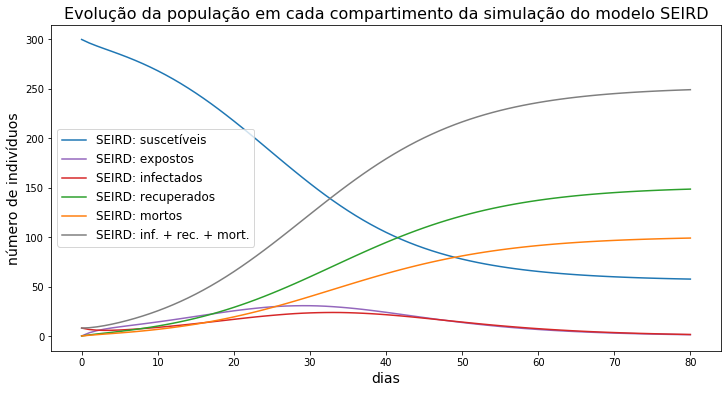

In [7]:
plt.figure(figsize=(12,6))

# exibe os gráficos das médias
plt.plot(tempos, X.S, 'tab:blue', label='SEIRD: suscetíveis')
plt.plot(tempos, X.E, 'tab:purple', label='SEIRD: expostos')
plt.plot(tempos, X.I, 'tab:red', label='SEIRD: infectados')
plt.plot(tempos, X.R, 'tab:green', label='SEIRD: recuperados')
plt.plot(tempos, X.D, 'tab:orange', label='SEIRD: mortos')
plt.plot(tempos, X.I + X.R + X.D, 'tab:gray', label='SEIRD: inf. + rec. + mort.')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução da população em cada compartimento da simulação do modelo SEIRD', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

Número de arestas: 44850
Número de vértices: 300
Número médio de conexões por indivíduo: 299.0


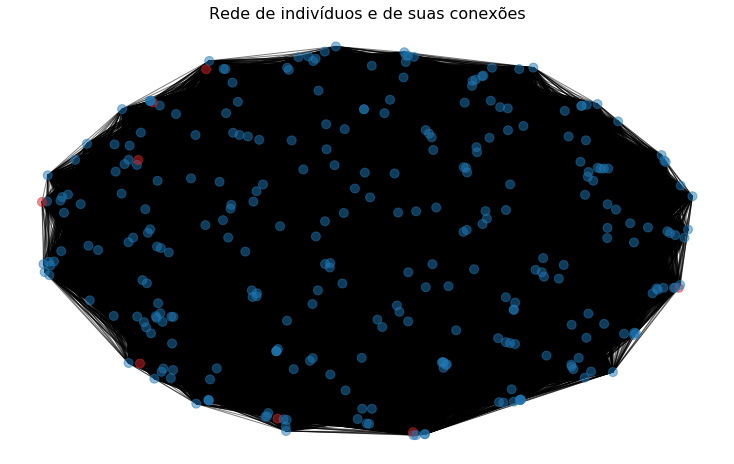

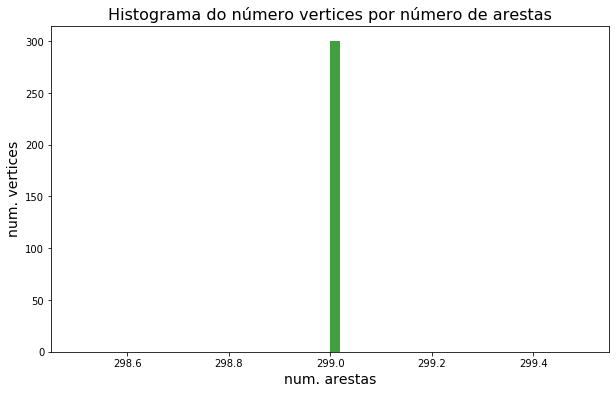

In [8]:
G_r = nx.random_regular_graph(d=num_pop-1, n=num_pop, seed=12)
nx.set_node_attributes(G_r, attr_pop_0)

num_medio_conexoes_r = analise_grafo(G_r, info=True, node_size=80, pos=None, hist=True)

Wall time: 0 ns


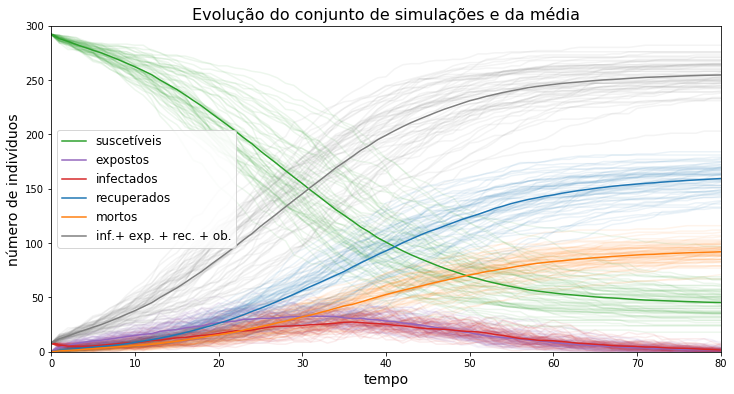

In [9]:
%time
X_r = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_r, delta, gamma, d, G_r, tempos,
                                 num_sim, show='nuvem')

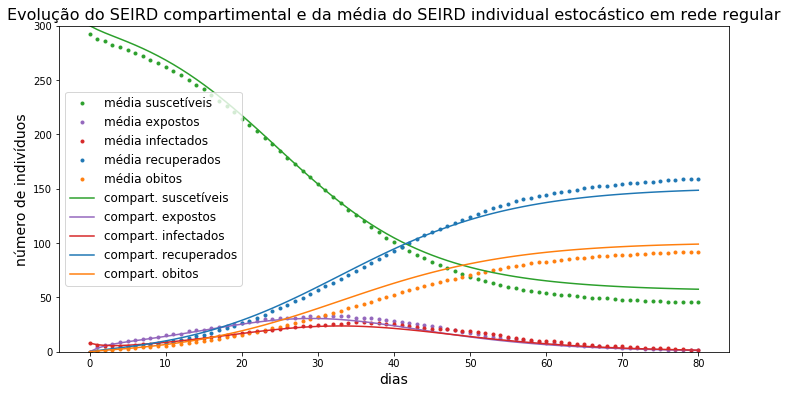

In [13]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_pop)

# exibe os gráficos das médias
plt.plot(tempos, X_r.S_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(tempos, X_r.E_mean, '.', color='tab:purple', label='média expostos')
plt.plot(tempos, X_r.I_mean, '.', color='tab:red', label='média infectados')
plt.plot(tempos, X_r.R_mean, '.', color='tab:blue', label='média recuperados')
plt.plot(tempos, X_r.D_mean, '.', color='tab:orange', label='média obitos')

plt.plot(tempos, X.S, 'tab:green', label='compart. suscetíveis')
plt.plot(tempos, X.E, 'tab:purple', label='compart. expostos')
plt.plot(tempos, X.I, 'tab:red', label='compart. infectados')
plt.plot(tempos, X.R, 'tab:blue', label='compart. recuperados')
plt.plot(tempos, X.D, 'tab:orange', label='compart. obitos')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title(f'Evolução do SEIRD compartimental e da média do SEIRD individual estocástico em rede regular', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

In [ ]:
G_er = nx.erdos_renyi_graph(num_pop, 6/num_pop, seed=12)
nx.set_node_attributes(G_er, attr_pop_0)

In [ ]:
num_medio_conexoes_er = analise_grafo(G_er, info=True, node_size=80, pos=None, hist=True)

In [ ]:
%time 
X_er = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_er, gamma, d, G_er, tempos,
                                  num_sim, show='sd')